In [245]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# =============================================================================
#                      AQUISIÇÃO E LIMPEZA DOS DADOS
# =============================================================================
try:
    # Usando auto_adjust=True para já tratar dividendos e splits.
    df_raw = yf.download('^BVSP', period='10y', interval='1d', auto_adjust=True)
    if df_raw.empty:
        raise ValueError("Nenhum dado foi baixado para o Ibovespa.")
    print(f"Dados baixados com sucesso. Total de {len(df_raw)} pregões.")
except Exception as e:
    print(f"Erro ao baixar os dados: {e}")
    exit()

df = df_raw[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df.columns = ['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Volume']
df.reset_index(inplace=True)

df.head(50)

[*********************100%***********************]  1 of 1 completed

Dados baixados com sucesso. Total de 2481 pregões.


,Date,Abertura,Maxima,Minima,Fechamento,Volume
0,2015-08-04,50138.0,50574.0,49827.0,50058.0,2670400
1,2015-08-05,50067.0,50853.0,50067.0,50287.0,2662100
2,2015-08-06,50280.0,50534.0,49624.0,50011.0,3640800
3,2015-08-07,50013.0,50013.0,48512.0,48577.0,3218400
4,2015-08-10,48578.0,49512.0,48578.0,49353.0,2842100
5,2015-08-11,49340.0,49340.0,48306.0,49072.0,3288000
6,2015-08-12,49064.0,49064.0,48028.0,48388.0,4234500
7,2015-08-13,48390.0,48606.0,47722.0,48010.0,3186500
8,2015-08-14,48010.0,48186.0,47508.0,47508.0,2878900
9,2015-08-17,47509.0,47788.0,47217.0,47217.0,2411800


In [ ]:
# =============================================================================
#                        CRIAÇÃO DAS FEATURES
# =============================================================================

df['Retorno'] = df['Fechamento'].pct_change()
df['SMA_10'] = df['Fechamento'].rolling(window=10).mean()
df['SMA_30'] = df['Fechamento'].rolling(window=30).mean()

delta = df['Fechamento'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

for lag in [1, 2, 3, 5]:
    df[f'Retorno_Lag_{lag}'] = df['Retorno'].shift(lag)

df['Volatilidade_10d'] = df['Retorno'].rolling(window=10).std()
df['Volatilidade_30d'] = df['Retorno'].rolling(window=30).std()

sma_20 = df['Fechamento'].rolling(window=20).mean()
bb_std = df['Fechamento'].rolling(window=20).std()

df['BB_Superior'] = sma_20 + (bb_std * 2)
df['BB_Inferior'] = sma_20 - (bb_std * 2)

df['Retorno_3d'] = df['Fechamento'].pct_change(periods=3)
df['Retorno_5d'] = df['Fechamento'].pct_change(periods=5)
df['Retorno_10d'] = df['Fechamento'].pct_change(periods=10)

exp1 = df['Fechamento'].ewm(span=12, adjust=False).mean()
exp2 = df['Fechamento'].ewm(span=26, adjust=False).mean()

macd = exp1 - exp2
macd_signal = macd.ewm(span=9, adjust=False).mean()

df['MACD_Hist'] = macd - macd_signal
print("\nEngenharia de atributos completa foi criada.")


Engenharia de atributos completa foi criada.


In [ ]:
# =============================================================================
#                PREPARAÇÃO DA BASE E DEFINIÇÃO DO TARGET
# =============================================================================
# Usando o horizonte de 5 dias, que se mostrou mais eficaz.
prediction_horizon = 5
df['Alvo'] = (df['Fechamento'].shift(-prediction_horizon) > df['Fechamento']).astype(int)
print(f"\nAlvo ajustado para prever a tendência em {prediction_horizon} dias.")
df_model = df.dropna()



Alvo ajustado para prever a tendência em 5 dias.


In [249]:
df_model

,Date,Abertura,Maxima,Minima,Fechamento,Volume,Retorno,SMA_10,SMA_30,RSI,...,Retorno_Lag_5,Volatilidade_10d,Volatilidade_30d,BB_Superior,BB_Inferior,Retorno_3d,Retorno_5d,Retorno_10d,MACD_Hist,Alvo
30,2015-09-16,47364.000000,48681.0000,47364.000000,48553.000000,4320300,0.025103,46985.100000,47219.100000,63.308287,...,-0.002245,0.014093,0.017404,48520.467085,44549.432915,0.046378,0.040637,0.067639,306.684726,0
31,2015-09-17,48553.000000,49396.0000,48082.000000,48551.000000,4184700,-0.000041,47193.800000,47161.233333,55.376897,...,-0.003279,0.013159,0.017374,48814.108738,44452.091262,0.026839,0.044018,0.044916,350.804942,0
32,2015-09-18,48550.000000,48550.0000,46928.000000,47264.000000,4381000,-0.026508,47183.600000,47069.666667,50.647059,...,-0.002215,0.015221,0.017974,48863.068356,44464.631644,-0.002111,0.018599,-0.002153,281.756871,0
33,2015-09-21,47263.000000,47391.0000,46425.000000,46590.000000,2601200,-0.014260,47192.800000,47003.433333,49.791811,...,0.018987,0.014726,0.017413,48861.925183,44552.774817,-0.040430,-0.014636,0.001979,183.874771,0
34,2015-09-22,46585.000000,46585.0000,45276.000000,46265.000000,4193100,-0.006976,47143.100000,46900.500000,55.037075,...,0.001734,0.014756,0.017132,48664.006169,44943.593831,-0.047085,-0.023203,-0.010628,94.904480,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,2025-07-29,132130.000000,133346.0000,132130.000000,132726.000000,6324800,0.004518,134021.600000,136598.866667,28.012577,...,-0.000976,0.008368,0.008054,141538.192126,130604.407874,-0.008086,-0.009773,-0.018662,-382.629698,0
2477,2025-07-30,132702.000000,134368.0000,131883.000000,133990.000000,8655300,0.009523,133869.500000,136437.200000,37.860482,...,0.009938,0.009064,0.008298,141171.760049,130464.739951,0.003490,-0.010180,-0.011224,-254.500438,0
2478,2025-07-31,133987.000000,133987.0000,132096.000000,133071.000000,9196800,-0.006859,133620.100000,136249.000000,36.686037,...,-0.011524,0.009221,0.008363,140334.822665,130515.977335,0.007129,-0.005508,-0.018397,-211.248227,0
2479,2025-08-01,132920.000000,133237.0000,132140.000000,132437.000000,8497100,-0.004764,133525.600000,136093.033333,37.500000,...,-0.002122,0.007867,0.008167,139145.844661,130800.855339,-0.002177,-0.008141,-0.007085,-204.793146,0


In [ ]:
# =============================================================================
#                    DIVISÃO DOS DADOS E ESCALONAMENTO
# =============================================================================
features = [
    'Maxima', 'Minima', 'Fechamento', 'Volume', 'SMA_10', 'SMA_30',
    'RSI', 'Retorno_Lag_1', 'Volatilidade_10d', 'Volatilidade_30d', 
    'BB_Superior', 'BB_Inferior', 'MACD_Hist', 'Retorno_3d', 'Retorno_5d', 'Retorno_10d'
] #'Abertura', 'Retorno_Lag_2', 'Retorno_Lag_3', 'Retorno_Lag_5', 'Retorno',
X = df_model[features]
y = df_model['Alvo']

test_size = 30
X_train = X[:-test_size]
y_train = y[:-test_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Usando {len(features)} features. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")

Usando 16 features. Treino: 2421 amostras, Teste: 30 amostras.


In [ ]:
# =============================================================================
#                          BUSCA DE HIPERPARÂMETROS
# =============================================================================
print("\n--- Iniciando a otimização de hiperparâmetros (GridSearchCV)... ---")
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'threshold': [0.002]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("\n--- Otimização Concluída ---")
print("Melhores parâmetros encontrados: ", grid_search.best_params_)
best_model = grid_search.best_estimator_


--- Iniciando a otimização de hiperparâmetros (GridSearchCV)... ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits



--- Otimização Concluída ---
Melhores parâmetros encontrados:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'threshold': 0.002}


c:\Users\YUPOPIC\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [11:49:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "threshold" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [252]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)


--- Resultados da Previsão (Melhor Modelo Encontrado) ---

Acurácia final do modelo otimizado: 76.67%

Relatório de Classificação:
              precision    recall  f1-score   support

   Baixa (↓)       0.81      0.91      0.86        23
    Alta (↑)       0.50      0.29      0.36         7

    accuracy                           0.77        30
   macro avg       0.65      0.60      0.61        30
weighted avg       0.74      0.77      0.74        30


Matriz de Confusão:


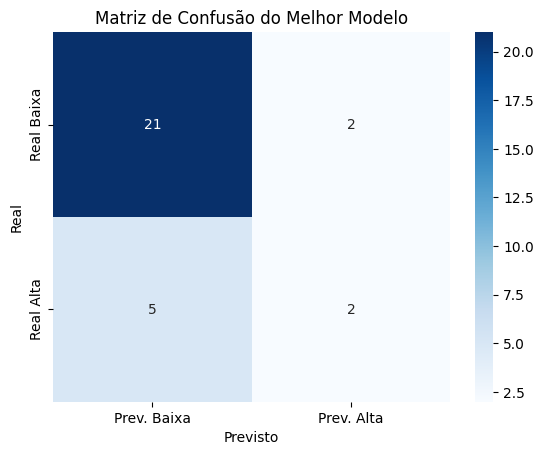

In [ ]:
# =============================================================================
#                     RESULTADOS E ANÁLISE DE MÉTRICAS
# =============================================================================
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n--- Resultados da Previsão (Melhor Modelo Encontrado) ---")
print(f"\nAcurácia final do modelo otimizado: {accuracy:.2%}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Baixa (↓)', 'Alta (↑)'], zero_division=0))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Prev. Baixa', 'Prev. Alta'], yticklabels=['Real Baixa', 'Real Alta'])
plt.title('Matriz de Confusão do Melhor Modelo')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()


--- Análise de Importância das Features (Melhor Modelo) ---
                  importance
SMA_30              0.085891
Fechamento          0.084662
Maxima              0.081818
MACD_Hist           0.077066
Volatilidade_30d    0.074955
BB_Superior         0.070355
Minima              0.068496
Retorno_5d          0.057944
SMA_10              0.057038
Retorno_10d         0.056453


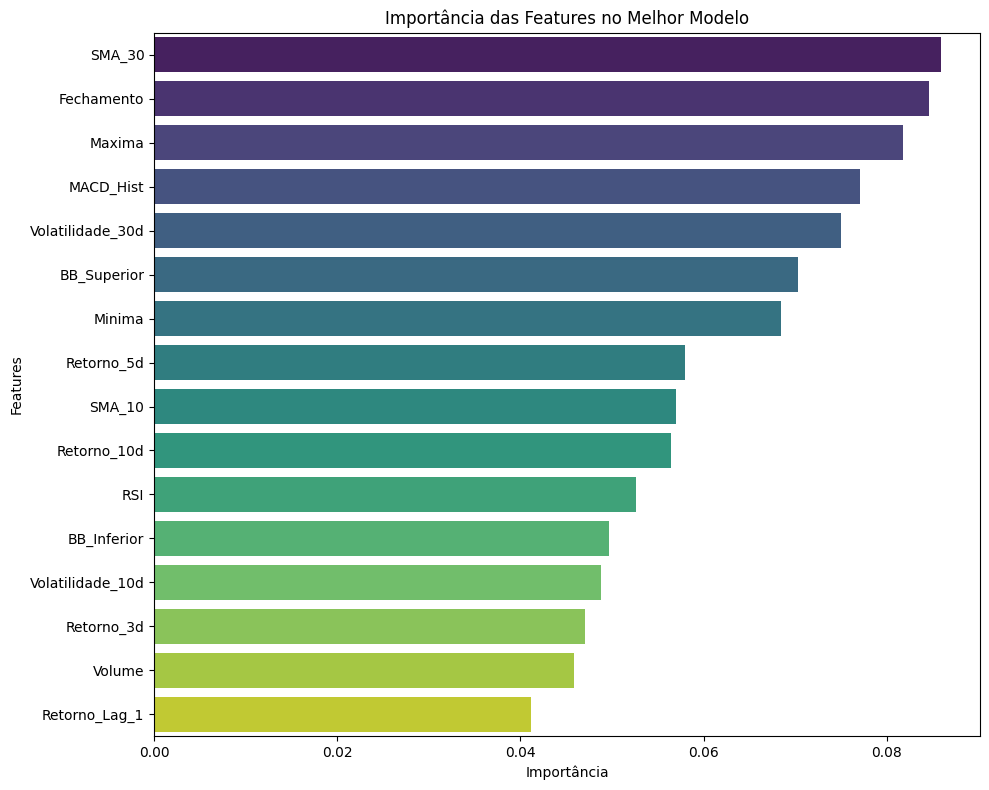

In [ ]:
# =============================================================================
#                 ANÁLISE DE IMPORTÂNCIA DAS FEATURES USADAS
# =============================================================================
print("\n--- Análise de Importância das Features (Melhor Modelo) ---")
feature_importances = pd.DataFrame(best_model.feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances, palette='viridis', hue=feature_importances.index, legend=False)
plt.title('Importância das Features no Melhor Modelo')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.tight_layout()
plt.show()